<a href="https://colab.research.google.com/github/Asklepiad/avians_neuronet/blob/main/avians.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install loguru

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 1.4 MB/s eta 0:00:00


In [1]:
import pickle
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import os
import seaborn as sns

from os.path import join
from loguru import logger
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch import nn
from IPython.display import clear_output
from sklearn.metrics import accuracy_score, f1_score

from sklearn.metrics import classification_report
import pandas as pd

In [2]:
from google.colab import files
from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google.colab'

In [9]:
#DATA_PATH = "/content/gdrive/MyDrive/avians/train"
DATA_PATH = "/home/asklepiad/bioinf/ml/BI_ML_2023/avians/train/"
RESCALE_SIZE = 224, 224
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32

print(f"Using device: {DEVICE}")

Using device: cpu


## Напишем класс `NematodDataset`

Рассказывали ли про `pathlib`?

In [10]:
class AviansDataset(Dataset):
    def __init__(self, files, mode="train") -> None:
        super().__init__()

        self.files = sorted(list(files))
        self.len_ = len(self.files)
        self.label_encoder = LabelEncoder()
        self.mode = mode

        self.labels = [path.parent.name for path in self.files]
        self.label_encoder.fit(self.labels)

        if self.mode == "train":
            with open("label_encoder.pkl", "wb") as le_dump_file:
                    pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        if self.mode == "train":
            transform = transforms.Compose([
                        transforms.Resize(size=RESCALE_SIZE),
                        transforms.RandomRotation(degrees=180),
                        # ADDITIONAL AUGMENTATIONS
                        transforms.ToTensor(),
                        #transforms.Normalize([0.572], [0.048])
            ])
        
        else:
            transform = transforms.Compose([
                        transforms.Resize(size=RESCALE_SIZE),
                        transforms.ToTensor(),
                        #transforms.Normalize([0.572], [0.048])
            ])

        x = self.load_sample(self.files[index])
        x = transform(x)
        label = self.labels[index]
        label_id = self.label_encoder.transform([label])
        y = label_id.item()

        return x, y

Оказывается, что не все изображения имеют 1 канал...

Исправить это можно двумя пуятми: просто убрать эти картинки или усреднять по первым трем каналам изображение, делая из него одноканальное. Реализуем второй вариант в `__getitem__`

## Класс для тренировки и валидации модели

In [11]:
class Trainer:
    def __init__(self, model, epochs, criterion,
                 optimizer, trainloader,
                 validloader, device, metric,
                 validate=True, scheduler=None,
                 verbose=2):
        self.model = model.to(device)
        self.epochs = epochs
        self.criterion = criterion
        self.optimizer = optimizer
        self.trainloader = trainloader
        self.validloader = validloader
        self.device = device
        self.metric = metric
        self.validate = validate
        self.verbose = verbose
        self.scheduler = scheduler
        self.get_probs = nn.Softmax(dim=0)
        self.train_losses = []
        self.valid_losses = []
        self.train_metrics = []
        self.valid_metrics = []

    def fit(self, epochs=None):
        if epochs is None:
            epochs = self.epochs

        for epoch in range(epochs):
            train_loss, train_metric = self._train(self.trainloader)
            self.train_losses.append(train_loss)
            self.train_metrics.append(train_metric)

            if self.validate:
                val_loss, val_metric = self._validate(self.validloader)
                self.valid_losses.append(val_loss)
                self.valid_metrics.append(val_metric)

                if self.scheduler is not None:
                    self.scheduler.step(val_loss)
            else:
                val_loss = "NO"

            if self.verbose > 0:
                print()
                print(f"Epoch {epoch+1} out of {epochs}: Train loss = {train_loss}, validation loss = {val_loss} \n\
                                         Train metric = {train_metric}, validation metric = {val_metric}")
                print()
        
        return self

    def _train(self, loader):
        self.model.train()
        epoch_loss = 0
        epoch_preds = []
        epoch_targets = []
        for i, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            out = self.model(inputs)
            loss = self.criterion(out, targets)
            epoch_loss += loss.item()
            self.optimizer.zero_grad()
            loss.backward()

            if self.verbose > 1:
                print(f"\rTraining: batch {i+1} out of {len(loader)}", end="")

            self.optimizer.step()

            out = self.get_probs(out)
            _, preds = torch.max(out.data, 1)
            epoch_preds += list(preds.cpu())
            epoch_targets += list(targets.detach().cpu())

            self._clear_vram(inputs, targets, out)

        epoch_loss = epoch_loss/len(loader)
        epoch_metric = self.metric(epoch_targets, epoch_preds)
        print("\n", end="")

        return epoch_loss, epoch_metric

    def _validate(self, loader):
        self.model.eval()
        epoch_loss = 0
        epoch_preds = []
        epoch_targets = []
        with torch.no_grad():
            for i, (inputs, targets) in enumerate(loader):
                inputs, targets = inputs.to(self.device), targets.to(self.device)              
                out = self.model(inputs)
                loss = self.criterion(out, targets)

                if self.verbose > 1:
                    print(f"\rValidation: batch {i+1} out of {len(loader)}", end="")

                epoch_loss += loss.item()
                out = self.get_probs(out)
                _, preds = torch.max(out.data, 1)
                epoch_preds += list(preds.cpu())
                epoch_targets += list(targets.detach().cpu())

                self._clear_vram(inputs, targets, out)

        epoch_loss = epoch_loss/len(loader)
        epoch_metric = self.metric(epoch_targets, epoch_preds)
        print("\n", end="")

        return epoch_loss, epoch_metric
    
    def _clear_vram(self, inputs, labels, outputs):
        inputs = inputs.to("cpu")
        labels = labels.to("cpu")
        outputs = outputs.to("cpu")
        del inputs, labels, outputs
        torch.cuda.empty_cache()

In [12]:
def predict(model, loader):
    model.eval()
    predictions = []
    targ = []
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)              
            out = model(inputs)
            out = nn.functional.softmax(out, dim=-1)
            _, preds = torch.max(out.data, 1)
            predictions += list(preds)
            targ += list(targets)
    
    return predictions, targ

def calculate_metric(model, loader, metric=None):
    if metric is None:
        metric = accuracy_score
    
    preds, targets = predict(model, loader)
    preds = [i.item() for i in preds]
    targets = [i.item() for i in targets]

    return metric(targets, preds)

Эта часть кода нужна лишь для того, чтобы из tiff сделать jpeg. Иначе в процессе получения батчей иногда возникали странные ошибки.

Получем список всех файлов. Создаем для каждого метку класса и делим на тренировку и валидацию.

In [13]:
# Мы пойдем своим путем: сначала сделаем кроссвалидацию на трэйне, потом будем сверяться с валом, а тест используем единственный раз -- в конце
train_val_files = sorted(list(Path(DATA_PATH).rglob("*.jpg")))
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)
N_CLASSES = len(set(train_val_labels))
N_CLASSES

525

In [53]:
from collections import Counter
d = dict(Counter(train_val_labels))
dict(sorted(d.items(), key= lambda x: x[1]))

{'AMETHYST WOODSTAR': 130,
 'EURASIAN GOLDEN ORIOLE': 130,
 'NORTHERN RED BISHOP': 130,
 'PATAGONIAN SIERRA FINCH': 130,
 'RED TAILED THRUSH': 130,
 'SNOWY PLOVER': 130,
 'BLACK FRANCOLIN': 131,
 'GO AWAY BIRD': 131,
 'INDIAN BUSTARD': 131,
 'MASKED LAPWING': 131,
 'TASMANIAN HEN': 131,
 'ALBATROSS': 132,
 'BALI STARLING': 132,
 'BARN SWALLOW': 132,
 'BARROWS GOLDENEYE': 132,
 'BLACK COCKATO': 132,
 'CHESTNET BELLIED EUPHONIA': 132,
 'MASKED BOOBY': 132,
 'ORANGE BRESTED BUNTING': 132,
 'ROCK DOVE': 132,
 'SCARLET TANAGER': 132,
 'SNOWY EGRET': 132,
 'AMERICAN GOLDFINCH': 133,
 'BLACK-CAPPED CHICKADEE': 133,
 'CAPE LONGCLAW': 133,
 'CAPUCHINBIRD': 133,
 'COMMON IORA': 133,
 'RED HEADED WOODPECKER': 133,
 'ANDEAN GOOSE': 134,
 'BLACKBURNIAM WARBLER': 134,
 'EASTERN BLUEBONNET': 134,
 'HARLEQUIN QUAIL': 134,
 'AFRICAN CROWNED CRANE': 135,
 'BLACK THROATED WARBLER': 135,
 'CRANE HAWK': 135,
 'EUROPEAN GOLDFINCH': 135,
 'GOLDEN CHLOROPHONIA': 135,
 'HOODED MERGANSER': 135,
 'MALLARD DUCK':

Важно посмотреть на распределение классов. Если оно у нас будет несбалансированным, то может быть, хорошей идеей поработать с этим (например, тот же upsampling редко представленных классов):

Создаем датасеты и даталоадеры.

In [14]:
trainset = AviansDataset(train_files)
valset = AviansDataset(val_files, mode="val")

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False)

Возьмем какую-то готовую модель, например, `VGG19` с батч-нормализацией:

In [15]:
model = torchvision.models.vgg19_bn(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:09<00:00, 61.9MB/s]


In [16]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

<center><img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img_license/l09_6.png"  width="400" rotate="180"></center>
<center><em>Сравнение архитектур сетей AlexNet, VGG16 (использует 16 слоев) и VGG19 (использует 19 слоев).</em></center>

На выходе у модели 1000 классов, а у нас 19. Мы уже знаем, как это изменить. Просто поменяем аттрибут `model.classifier` на линейный слой с нужным числов выходов (можно на несколько линейных слоев, помещенных в `nn.Sequential`).

Но возникает проблема поинтереснее: на входе модель ожидает картинку с 3 каналами, а у нас 1. Один из вариантов (он не самый хороший) это просто поменять первый сверточный слой в модели и обучать ее целиком (**подумайте**, почему мы не можем заморозить все слои кроме новых и обучать так модель?).

In [17]:
num_features = 25088
model.classifier = nn.Linear(num_features, N_CLASSES)
model = model.to(DEVICE)

In [18]:
# Была мысль сделать скорость обучения побольше. Ну потому что не может модель учиться медленнее меня, какой в ней тогда смысл.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=3, factor=0.5)

In [19]:
trainer = Trainer(model, 10, criterion, optimizer, trainloader, valloader, DEVICE, accuracy_score)
trainer.fit()

Training: batch 76 out of 76
Validation: batch 26 out of 26

Epoch 1 out of 10: Train loss = 1.1954157250492197, validation loss = 0.5608964793276615 
                                         Train metric = 0.5897119341563786, validation metric = 0.2

Training: batch 76 out of 76
Validation: batch 26 out of 26

Epoch 2 out of 10: Train loss = 0.4968737452045867, validation loss = 0.6462800293789209 
                                         Train metric = 0.7078189300411523, validation metric = 0.17901234567901234

Training: batch 76 out of 76
Validation: batch 26 out of 26

Epoch 3 out of 10: Train loss = 0.40923851150039, validation loss = 0.49684865717203 
                                         Train metric = 0.7271604938271605, validation metric = 0.2419753086419753

Training: batch 76 out of 76
Validation: batch 26 out of 26

Epoch 4 out of 10: Train loss = 0.34188879607245326, validation loss = 0.7054609288103305 
                                         Train metric = 0.7320987

Нематоды обучились за полчаса. 20 семейств птичек (а всего их то ли 1100, то ли 500 с копейками) за 50 минут

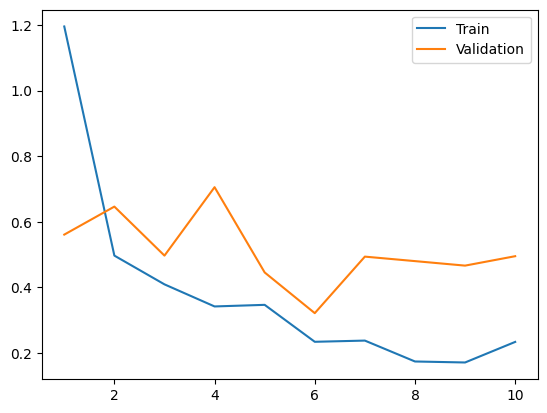

In [20]:
sns.lineplot(y=trainer.train_losses, x=range(1, 11), label="Train")
sns.lineplot(y=trainer.valid_losses, x=range(1, 11), label="Validation")

plt.show()

In [21]:
print(calculate_metric(model, valloader))

0.891358024691358

In [22]:
from functools import partial

f1_macro = partial(f1_score, average="macro")
f1_micro = partial(f1_score, average="micro")

In [23]:
print(calculate_metric(model, valloader, f1_macro))

0.8959382913031483

In [24]:
print(calculate_metric(model, valloader, f1_micro))

0.891358024691358

Смотрим на предсказания

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()

    return probs


def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp.reshape(*RESCALE_SIZE), cmap="gray")
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)


def get_predicts(model, test_loader):
    with torch.no_grad():
        logits = []
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()

    return probs

In [ ]:
label_encoder = trainset.label_encoder

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(16, 16), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 500))
    im_val, label = valset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                valset.label_encoder.inverse_transform([label])[0].split("_")))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label, plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53), 86, 35, color="white"))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + "\n" + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.2f}".format(predicted_label, predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment="left", fontproperties=font,
                    verticalalignment="top", fontsize=14, color="black", fontweight="bold")

In [ ]:
val_images = [valset[id][0].unsqueeze(0) for id in range(len(valset))]
val_predictions = get_predicts(model, val_images)

y_pred_val = np.argmax(val_predictions, -1)
actual_labels = [valset[id][1] for id in range(len(valset))]
preds_class = [label_encoder.classes_[i] for i in y_pred_val]

val_mertics_report = pd.DataFrame(classification_report(actual_labels, y_pred_val, output_dict=True)).T
val_mertics_report.index = list(label_encoder.inverse_transform(np.arange(19))) + ["accuracy", "macro avg", "weighted avg"]

In [ ]:
val_mertics_report